In [1]:
from mantle_utils.workflow.enqueue import get_raster_stack_paths_and_metadata
from mantle_utils.workflow.process import sanitize_raster_stack_paths_and_metadata
import pandas as pd
from prophet import Prophet
from pathlib import Path
from mantle_utils.alg.raster import Raster
from rasterio.windows import Window
import numpy as np
from multiprocessing import Pool

/cats/datastore3/anaconda3_envs/adia/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def compute(idx,ip, sorted_datetimes):#df will not be the input, i,j will be
    df = {'ds':sorted_datetimes,'y':ip[:,idx[0],idx[1]]}
    df = pd.DataFrame(df)
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=1)
    forecast = m.predict(future)
    #out[i][j]=
    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    fig1.savefig('trend%s%s.svg'%(str(idx[0]),str(idx[1]))
    fig2.savefig('comp%s%s.svg'%(str(idx[0]),str(idx[1]))
    #np.save('prediction.npy',out)
    return [forecast['yhat'].values[0],i,j]

In [ ]:
#3 things need to be done, 
#0. Save the trends in file, visualize them over time, and see if you need to take the alternate values, but first parallize it else it’ll take a lot of time to do this
#1. Parallize a certain date over multiple threads
#Will need to convert it into a .py file as multiprocessing
#2.Need to do this for all the dates, will need to figure out a way to loop over the dates

In [ ]:
if __name__ == "__main__":
    stack_raster_paths, stack_metadata = \
    get_raster_stack_paths_and_metadata(
        env_name='production',
        stacking_source_run_name='nirlipta_30UXB_stack',
        tile_idx='30UXB',
        raise_on_inconsistent_stack=False)

    stack_df = sanitize_raster_stack_paths_and_metadata(
    raster_paths=stack_raster_paths,
    stack_metadata=stack_metadata,
    sanitize_paths=False)
    size = [80,50]
    window = Window(col_off=100, row_off=200, width=size[0], height=size[1])
    #loop through time do it in a continous manner???
    stack_df = stack_df[np.logical_and(stack_df['start_datetime'] >= np.datetime64('2019-01-01'), stack_df['start_datetime'] < np.datetime64('2019-04-01'))]
    stack_df = stack_df.loc[stack_df['source_artefact_name'] == 'VVVH']
    sorted_datetimes = sorted(list(set(
    stack_df['start_datetime'].values)))
    ip = []
    for start_datetime_np in sorted_datetimes:
       # print(stack_df.loc[stack_df['start_datetime'] == start_datetime_np]['raster_path'].values)
        geotiff_path = stack_df.loc[stack_df['start_datetime'] == start_datetime_np]['raster_path'].values[0]
        partial_raster = Raster(geotiff_path, window=window)
        temp = partial_raster.array.reshape(size[1],size[0])
        ip.append(temp)
    #pdb.set_trace()
    ip = np.array(ip) 
    # df is the  final dataset, 1D in this case, with 2 columns, time and Y values
    out = np.zeros(size[::-1])
    i = range(size[1])
    j = range(size[0])
    paramlist = list(itertools.product(i,j))
    #Generate processes equal to the number of cores
    with Pool() as pool:
    #Distribute the parameter sets evenly across the cores
        res = pool.starmap(compute,zip(paramlist,ip,sorted_datetimes))
        for i in range(len(paramlist)):
            out[res[i][1]][res[i][2]] = res[i][0]
        



In [15]:
def func(a,b):
    add = a+b
    diff = a-b
    return [add,a,b]

In [23]:
from multiprocessing import Pool
import numpy as np
import itertools
if __name__ == "__main__":
    i = range(5)
    j = range(4)
    paramlist = list(itertools.product(i,j))
    out = np.zeros([5,4])
    with Pool() as pool:
    #Distribute the parameter sets evenly across the cores
        res = pool.starmap(func,paramlist)
        res = np.array(res)
        res = np.reshape(res,[3])
        out[res[1]][res[2]] = res[0]
    

OSError: [Errno 12] Cannot allocate memory

In [29]:
from multiprocessing import Pool
import numpy as np
import itertools
#import pdb


def func(a, b):
    add = a + b
    return [add, a, b]


if __name__ == "__main__":
    i = range(5)
    j = range(4)
    paramlist = list(itertools.product(i, j))
    out = np.zeros([5, 4])
    with Pool() as pool:
        # Distribute the parameter sets evenly across the cores
        res = pool.starmap(func, paramlist)
        res = np.array(res)
        # res = np.reshape(res, [len(paramlist), 3])
        for i in range(len(paramlist)):
            out[res[i][1]][res[i][2]] = res[i][0]
        #pdb.set_trace()

In [28]:
out

array([[0., 1., 2., 3.],
       [1., 2., 3., 4.],
       [2., 3., 4., 5.],
       [3., 4., 5., 6.],
       [4., 5., 6., 7.]])

In [36]:
idx = [1,2]

filename = "trend%s%s.csv"%(str(idx[0]),str(idx[1]))


print(filename)

trend12.csv


In [2]:
import datetime
from mantle_utils.workflow.enqueue import get_raster_stack_paths_and_metadata
from mantle_utils.workflow.process import sanitize_raster_stack_paths_and_metadata
from mantle_utils.workflow.metadatadb.product import ProductCollection
from mantle_utils.workflow.metadatadb.product import create_s2_tile_idx_search_dict
from mantle_utils.workflow.metadatadb.product import create_datetime_search_dict

stacking_source_run_name = 'nirlipta_30UXB_stack'
tile_idx = '30UXB'

stack_raster_paths, stack_metadata = \
    get_raster_stack_paths_and_metadata(
        env_name='production',
        stacking_source_run_name=stacking_source_run_name,
        tile_idx=tile_idx,
        raise_on_inconsistent_stack=False)
   
stack_df = sanitize_raster_stack_paths_and_metadata(
    raster_paths=stack_raster_paths,
    stack_metadata=stack_metadata,
    sanitize_paths=False)

product_collection = ProductCollection()

product_tile_search_dict = \
    create_s2_tile_idx_search_dict(tile_idx=tile_idx)

s1_stack_df = stack_df[stack_df['source_workflow_name'] == 's1-generate_composites']

for start_datetime_np in sorted(list(set(
        s1_stack_df['start_datetime'].values))):

    # cf. https://stackoverflow.com/questions/13703720/converting-between-datetime-timestamp-and-datetime64  # NOQA:501
    start_datetime = datetime.datetime.utcfromtimestamp(
        start_datetime_np.astype(int) * 1e-9)

    product_datetime_search_dict = \
        create_datetime_search_dict(
            datetime=start_datetime)
    
    search_dict = {
        'product_metadata.year': start_datetime.year,
        'product_metadata.month': start_datetime.month,
        'product_metadata.day': start_datetime.day,
        **product_tile_search_dict}

    products = product_collection.find_in_db(
        env_name='production',
        projection_dict={
            '_id': 0,
            'product_metadata.pass': 1},
        workflow_name='s1-generate_s2tiles',
        run_name='v1.0-v1.0',
        search_dict=search_dict)
    
    if len(products) == 0:  # no entry was found
        continue

    #print(products[0]['product_metadata']['pass'])

In [3]:
products

[{'product_metadata': {'pass': 'ASCENDING'}}]

In [4]:
type(products)

list

In [5]:
len(products)

1

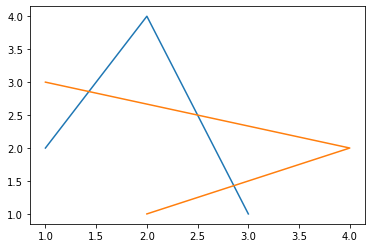

In [13]:
0b os.path
import matplotlib.pyplot as plt 
c = 0b0
a= 1
b= 2
save_path_t=''
save_path_c=''
if(c&0b1 == 0):
    save_path_t = './single_op_asc_dsc/asc/trends/'
    save_path_c = './single_op_asc_dsc/asc/comp/'
if(c&0b1 == 1):
    save_path_t = './single_op_asc_dsc/dsc/trends/'
    save_path_c = './single_op_asc_dsc/dsc/comp/'
    
# x axis values 
x = [1,2,3] 
# corresponding y axis values 
y = [2,4,1] 
    
# plotting the points  
plt.plot(x, y)
plt.savefig(os.path.join(save_path_t,'%s_%s.svg'%(str(0),str(0))))
y = [1,2,3] 
# corresponding y axis values 
x = [2,4,1] 
    
# plotting the points  
plt.plot(x, y) 
#print(ip)

plt.savefig(os.path.join(save_path_c,'%s_%s.svg'%(str(0),str(0))))

In [4]:
def func(a,b):
    add = a+b
    diff = a-b
    out = add
    if (c&0b1==1):
        out = diff
    return out

In [6]:
global c
c = 0b0
a = 7
b = 3
print(func(a,b))
c = 0b1
print(func(a,b))

10
4


In [7]:
import pandas as pd  
  
# assign data of lists.  
data = {'Name': ['Tom', 'Joseph', 'Krish', 'John'], 'Age': [20, 21, 19, 18]}  
  
# Create DataFrame  
df = pd.DataFrame(data)  
  

In [9]:
df.loc[df['Age']<20]

,Name,Age
2,Krish,19
3,John,18


In [11]:
df[df['Age']<20]

,Name,Age
2,Krish,19
3,John,18


In [12]:
df

,Name,Age
0,Tom,20
1,Joseph,21
2,Krish,19
3,John,18
